In [3]:
!pip install spotipy

  Using cached spotipy-2.25.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached redis-6.2.0-py3-none-any.whl.metadata (10 kB)
Using cached spotipy-2.25.1-py3-none-any.whl (31 kB)
Using cached redis-6.2.0-py3-none-any.whl (278 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from datetime import datetime

# Spotify credentials
client_id = '62f989661df64119a5cc84aad0a37864'
client_secret = '3b66ae3c84c2408481bb0179e81c481f'

# Authenticate
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Get artist ID
result = sp.search(q='Sabrina Carpenter', type='artist', limit=1)
artist_id = result['artists']['items'][0]['id']

# Get all albums/singles
albums = sp.artist_albums(artist_id, album_type='album,single', country='US', limit=50)
album_ids = list({album['id'] for album in albums['items']})

# Fetch track details
tracks = []
for album_id in album_ids:
    album = sp.album(album_id)
    release_date = album['release_date']
    for track in album['tracks']['items']:
        track_data = sp.track(track['id'])
        tracks.append({
            'name': track['name'],
            'album': album['name'],
            'release_date': release_date,
            'popularity': track_data['popularity'],
            'duration_ms': track_data['duration_ms'],
            'spotify_url': track_data['external_urls']['spotify']
        })

# Create DataFrame
df = pd.DataFrame(tracks)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])

# Calculate age in days/months
today = pd.Timestamp.today()
df['days_since_release'] = (today - df['release_date']).dt.days
df['months_since_release'] = df['days_since_release'] / 30

# Create popularity per month metric
df['popularity_per_month'] = df['popularity'] / df['months_since_release'].replace(0, 1)

# Save or display
df_sorted = df.sort_values(by='popularity_per_month', ascending=False)
print(df_sorted[['name', 'album', 'release_date', 'popularity', 'months_since_release', 'popularity_per_month']])


In [6]:
from datetime import date
import os


In [8]:

df['snapshot_date'] = date.today()
df.to_csv('sabrina_popularity_history.csv', mode='a', header=not os.path.exists('sabrina_popularity_history.csv'), index=False)




C:\Users\HP\AppData\Local\Temp\ipykernel_24148\1603609934.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


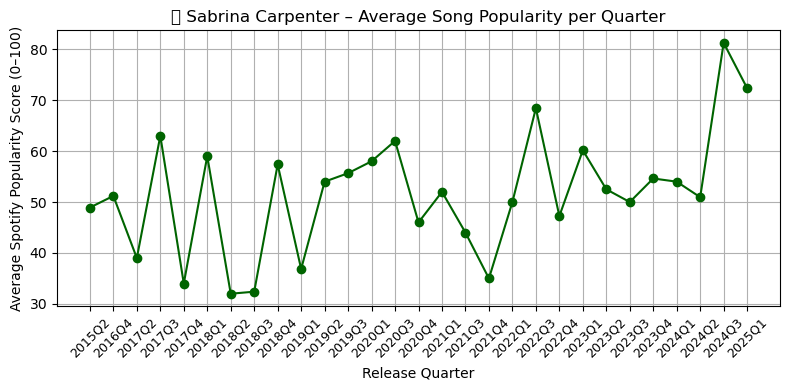

In [35]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("sabrina_tracks_popularity.csv", on_bad_lines='skip')


df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date', 'popularity'])


df['quarter'] = df['release_date'].dt.to_period('Q')


quarterly_avg = df.groupby('quarter')['popularity'].mean().reset_index()


quarterly_avg['quarter'] = quarterly_avg['quarter'].astype(str)

plt.figure(figsize=(8, 4))
plt.plot(quarterly_avg['quarter'], quarterly_avg['popularity'], marker='o', linestyle='-', color='darkgreen')
plt.xticks(rotation=45, fontsize=9)
plt.title("Sabrina Carpenter – Average Song Popularity per Quarter")
plt.xlabel("Release Quarter")
plt.ylabel("Average Spotify Popularity Score (0–100)")
plt.grid(True)
plt.tight_layout()
plt.show()

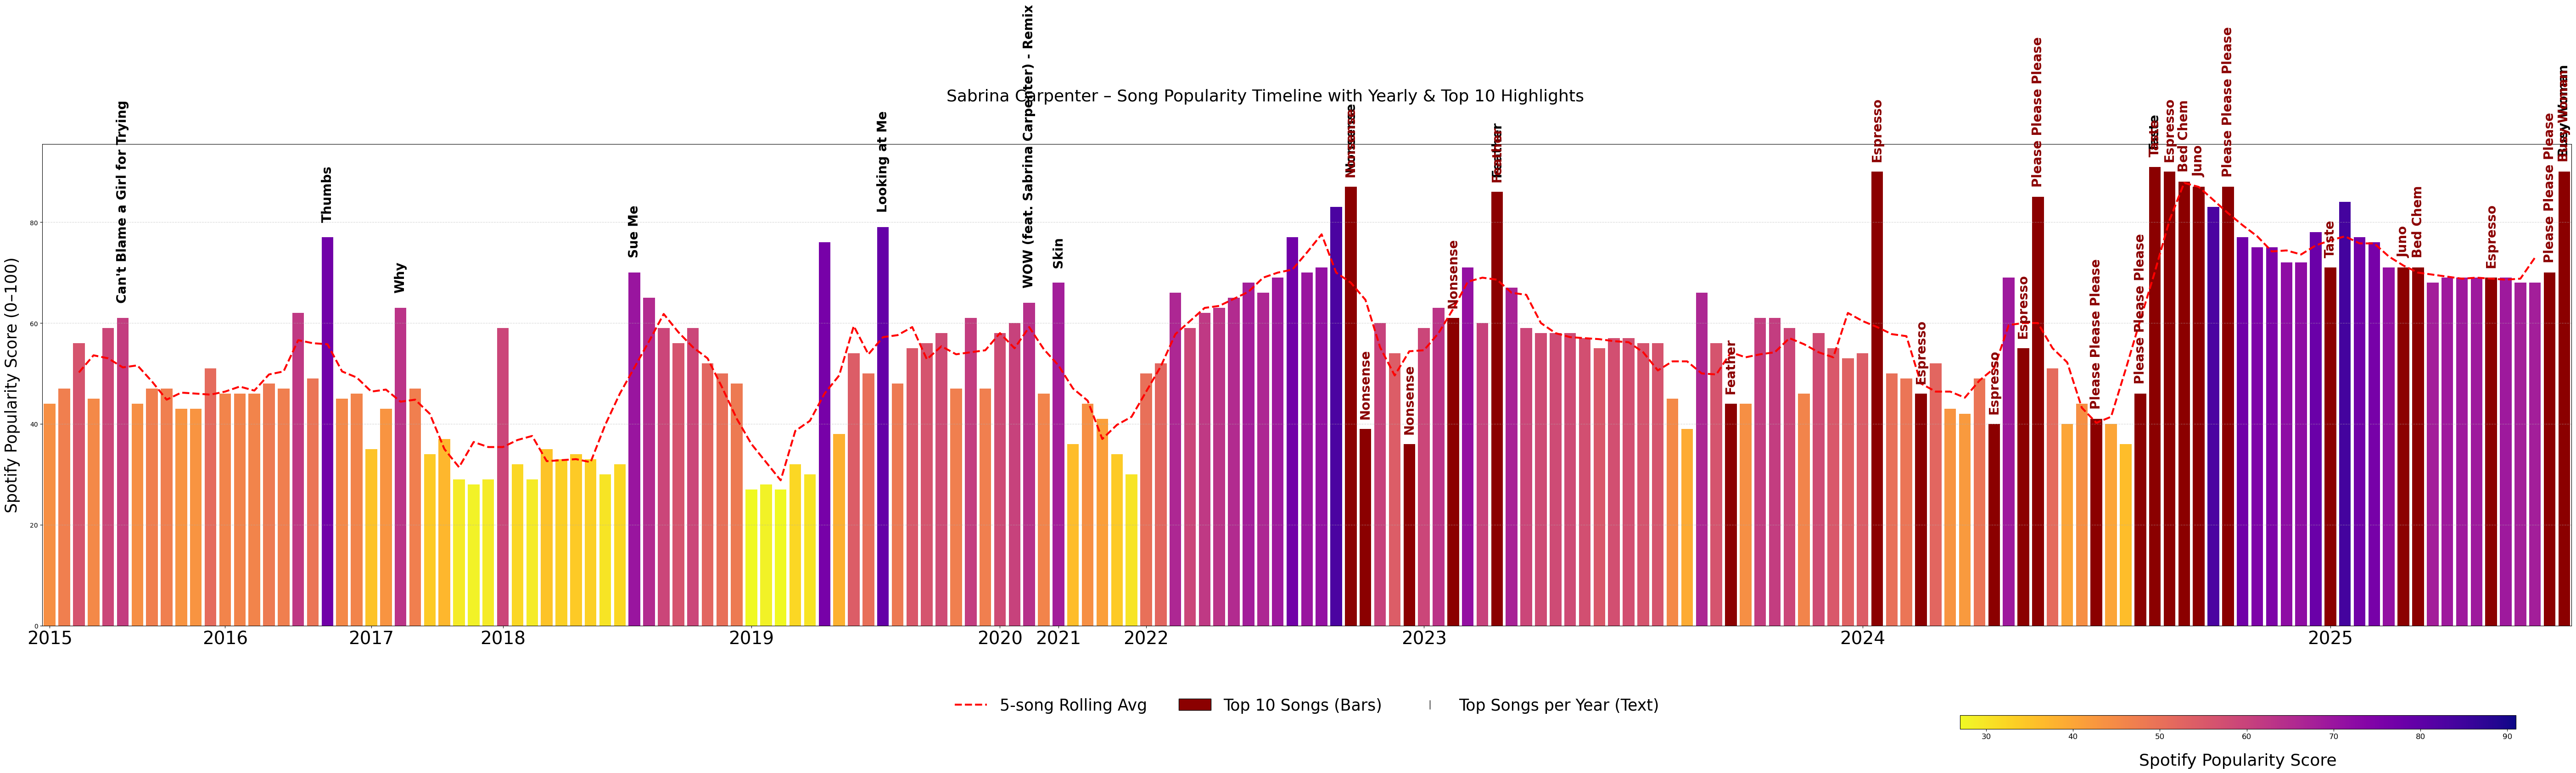

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# === Load CSV File ===
df = pd.read_csv('sabrina_tracks_popularity.csv', on_bad_lines='skip')

# === Clean and Prepare ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date', 'popularity', 'name'])
df['year'] = df['release_date'].dt.year

# Sort by release date
df = df.sort_values('release_date').reset_index(drop=True)

# Colormap: Darker = More Popular
cmap = cm.plasma_r
norm = mcolors.Normalize(vmin=df['popularity'].min(), vmax=df['popularity'].max())
colors = cmap(norm(df['popularity']))

# Identify top 10 songs
top10 = df.sort_values(by='popularity', ascending=False).head(10)
df['is_top10'] = df['name'].isin(top10['name'].values)

# Enhance top 10 colors: Red for top 10, plasma for others
highlight_color = 'darkred'
bar_colors = [highlight_color if is_top else color for is_top, color in zip(df['is_top10'], colors)]

# Rolling average of popularity (trend line)
df['rolling_avg'] = df['popularity'].rolling(window=5, center=True).mean()

# === Find top song per year ===
top_per_year = df.loc[df.groupby('year')['popularity'].idxmax()]

# === Plot ===
fig, ax = plt.subplots(figsize=(max(20, len(df) * 0.35), 15))
bars = ax.bar(range(len(df)), df['popularity'], color=bar_colors)

# Fix extra whitespace on left and right
ax.set_xlim(-0.5, len(df) - 0.5)

# Annotate top song per year
for i, row in top_per_year.iterrows():
    ax.text(row.name, row['popularity'] + 3, f"{row['name']}",
            rotation=90, fontsize=20, fontweight='bold',
            ha='center', va='bottom', color='black')

# Annotate top 10 songs (bold, larger font, dark red)
for i, row in df.iterrows():
    if row['is_top10']:
        ax.text(i, row['popularity'] + 2, row['name'],
                rotation=90, fontsize=20, fontweight='bold',
                ha='center', va='bottom', color=highlight_color)

# Set year labels only when year changes
tick_positions = []
tick_labels = []
previous_year = None
for i, year in enumerate(df['year']):
    if year != previous_year:
        tick_positions.append(i)
        tick_labels.append(str(year))
        previous_year = year

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=28)
ax.set_ylabel("Spotify Popularity Score (0–100)", fontsize=25, labelpad=15)

# Add rolling average trend line
trend_line, = ax.plot(df.index, df['rolling_avg'], color='red', linestyle='--', linewidth=3)

# === Legend at Bottom ===
legend_elements = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=3, label='5-song Rolling Avg'),
    Patch(facecolor=highlight_color, edgecolor='black', label='Top 10 Songs (Bars)'),
    Line2D([0], [0], color='black', marker='|', markersize=15, linestyle='None', label='Top Songs per Year (Text)')
]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, fontsize=25, frameon=False)

# === Colorbar ===
cbar_ax = fig.add_axes([0.75, 0.05, 0.2, 0.02])
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Spotify Popularity Score', fontsize=26, labelpad=20)
cbar.ax.tick_params(labelsize=12)

# Final layout tweaks
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(left=0.06, right=0.97, top=0.9, bottom=0.20)  # More bottom space for legend

# Global figure title 
fig.suptitle("Sabrina Carpenter – Song Popularity Timeline with Yearly & Top 10 Highlights", fontsize=26, y=0.98)

plt.show()
